# Kenji Oman Milestone Presentation, 15 March 2018
Completed in fulfillment of the UW Data Science Certificate, Data Science: Process and Tools class, Presentation Assignment
<!---<div style="background-color: floralwhite; border-radius: 3px;">--->

Instructions:
<ol>
    <li> Use the empty code blocks to paste in your Python code. <b>Insert Cell</b> to add more.</li>
    <li> Double-click or change cell to Markdown type to add explanations.</li>
    <li> <b>Cell > Run All</b> to run the code or <b>CTRL + ENTER</b> in each block.</li>
    <li> <b>File > Download as HTML</b> to export a static copy including code output.</li>
    </ol>
</div>

## Data Question:
What can we learn from the Adult Census dataset? Can we accurately predict, which individuals make over $50 thousand?

### Data Peak
Data from [UCI Machine Learning Repsitory](https://archive.ics.uci.edu/ml/datasets/Adult)
```
39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, <=50K
```

### Header file (adult.names) Peak:
```
...

>50K, <=50K.

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
```

### Initializations

In [1]:
%matplotlib inline

import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as skm

In [2]:
# Define the URL's for the training and test data
TRAIN_URL = ('https://archive.ics.uci.edu/ml/machine-learning-databases/'
             'adult/adult.data')

TEST_URL = ('https://archive.ics.uci.edu/ml/machine-learning-databases/'
            'adult/adult.test')

# And define the URL of the file which contains the header names
HEADER_URL = ('https://archive.ics.uci.edu/ml/machine-learning-databases/'
              'adult/adult.names')

In [3]:
class DataProject(object):
    """
    Just use a class to group all methods together, especially if we're going
    to be building on our work through each assignment.
    """

    def __init__(self, train, test, head):
        """Initialize the class when we instantiate it.

        Args:
            train (str): URL of the training set data
            test (str): URL of the test set data
            head (str): URL of the header location

        Attributes:
            self.train_url = train
            self.test_url = test
            self.head_url = head
            self.train_df = pd.DataFrame of trainig Data
            self.test_df = pd.DataFrame of the test Data
        """

        # Save the URL's, in case we want it later
        self.train_url = train
        self.test_url = test
        self.head_url = head

        # Grab the data, and store the internal variables
        self._get_data()


    def _get_data(self):
        """"Internal method to get the data and associate it with the class.
        Used in self.__init__
        """

        # Grab the data. Note, the separator is actually ', ', not just a
        # comma, so specify. Also, recognize the "?" as an NA value
        # (I think it is easier to have pandas catch the NA values instead
        #  of manually searching for and parsing these in the future).
        # Finally, set the engine to python, since having a separator greater
        # than one character automatically does this, and prints a warning
        # message.  By explicitly telling it to use python, we suppress the
        # warning.
        self.train_df = pd.read_csv(self.train_url, sep=', ', header=None,
                                    na_values='?', engine='python')

        # For the training data, have one comment row, so need to ignore
        self.test_df = pd.read_csv(self.test_url, sep=', ', header=None,
                                   skiprows=1, na_values='?', engine='python')

        # Get the header data
        response = requests.get(self.head_url)
        header = response.text.split('\n')

        # Now, filter to grab the header lines:
        # First, make sure there is at least one character for the line, and
        # ignore lines that start with the comment character for the file "|"
        header = [row for row in header if len(row) > 0 and row[0] != '|']

        # Ignore the first row, since it is just identifying the classifier
        # task and, get just the header values
        header = [head.split(':')[0] for head in header[1:]]

        # Finally, we need to add a header name for the last column (if <= or >
        # income of 50k)
        header.append('income')

        # Since it's hard to access df elements if they have a '-' (we have
        # to explicitly use df[colname] notation, instead of just df.colname)
        # let's convert all hyphens in column names into underscores
        header = ['_'.join(col.split('-')) for col in header]

        # Now, set the header for the data sets
        self.train_df.columns = header
        self.test_df.columns = header
        
    def get_na_cols(self, df):
        """Get columns with null values from the specified dataframe that
        are associated with this class
        
        Args:
            df (str): Name of the dataframe associated with this class instance
                For example, if the instance of this class is mydata,
                then check if mydata.train_df has any columns with null values
                by calling mydata.get_na_cols('train_df')

        Returns:
            pd.Index: A pd.Index object with all the column names that have
                a null value.
        """

        # Make sure we are given a string
        assert type(df) == str, 'Need to give a string!'

        # Try to get this dataframe from this class
        try:
            df = getattr(self, df)

            # Assert that what we got is indeed a pd.DataFrame
            assert type(df) is pd.core.frame.DataFrame, "Didn't grab a df!"

        except AttributeError:
            print("\"{}\" isn't a part of the class!".format(df))
            raise

        # Now, return columns with a null
        return df.columns[df.isnull().any()]

In [4]:
# Instantiate my class with the raw data
my_data = DataProject(TRAIN_URL, TEST_URL, HEADER_URL)

### Exploratory Data Analysis/ Value Consolidation
First, let's take a look at which columns have missing data:

In [5]:
# Check missing Data:
my_data.get_na_cols('train_df')

Index(['workclass', 'occupation', 'native_country'], dtype='object')

We see that these are all categorical columns, so let's look at Numeric columns for now

#### Numeric Data Explorations

In [6]:
# Basic statistics of numeric columns
my_data.train_df.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


First, we see that **education_num** is a column ranging afrom 1 to 16, and if we look at the details, we find that it matches directly with the education column (it is a numerical encoding of a categorical column).  So, **let's eventually drop this column**, since it doesn't mean much to us on its own. Also, fnlwgt is a weighting factor for how to turn each line into accurate values for the population at large, but it is poorly documented, so lets just drop it too (drop this one now, drop education_num later).

In [7]:
# Drop fnlwgt
my_data.train_df.drop('fnlwgt', axis=1, inplace=True)
my_data.test_df.drop('fnlwgt', axis=1, inplace=True)

We see an age range from 17-90! (some individuals having an income even at an older age!)  Also, most individuals have no capital gain/ capital loss, and people work out to 99 hours per week! (with everyone at least claiming to work at least one hour per week).  Let's take a look at this graphically:

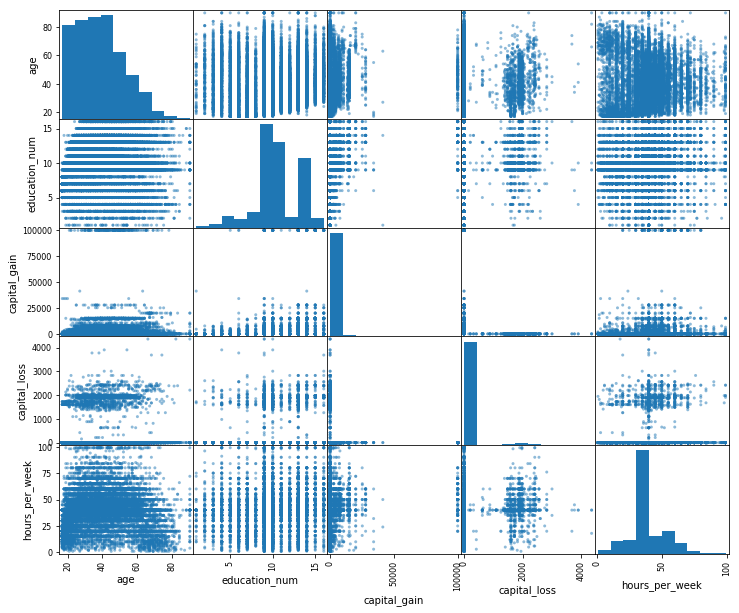

In [8]:
# Show data
pd.plotting.scatter_matrix(my_data.train_df, figsize=(12,10))
plt.show()

A few things to notice:
1. Capital gain vs capital loss -- only seem to have non-zero values in one when the other is zero (I verified this, but won't show my work)
2. Looking at the distribution of capital gain, it looks like we have outlier values at ~\$100,000
3. Looking at age vs hours per week, we seem to have outlier values at the max age (90) and max hours per week (99).

Let's check the distribution of Capital Gain without the zero values (so we can actually see the distribution of non-zero values)

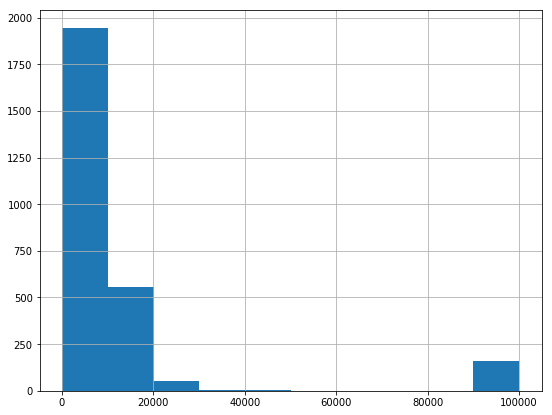

In [9]:
# Histogram of non-zero capital gain values
my_data.train_df['capital_gain'][my_data.train_df['capital_gain'] != 0].hist(figsize=(9,7))
plt.show()

We see that we indeed have outliers at the highest capital gain values. Looking at everything but capital gain = 0 or 99,999 (the highest value):

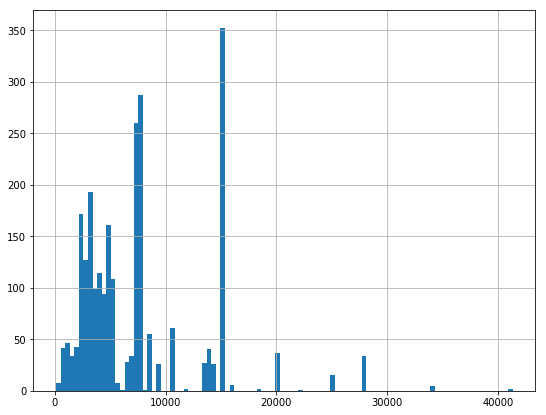

In [10]:
f = plt.figure(figsize=(9,7))
ax = f.add_subplot(111)
my_data.train_df['capital_gain'][
    (my_data.train_df['capital_gain'] != 0) &
    (my_data.train_df['capital_gain'] < 75000)].hist(bins=100, ax=ax)
plt.show()

We see an interesting distribution of remaining values (what are the peaks at ~7 thousand and at ~15 thousand?).  My best guess is these are **_related to standard cutoffs for bond values, or perhaps standard rates of tax cutoffs_**, but I'd have to investigate financial capital gain sources/ tax laws to be sure.

Returning to our outliers, I was originally going to re-assign them values based on the other non-zero capital gain distribution, but upon further thought, I believe **_these are capital gain values that were actually greater than \$100,000, truncated down_** to the max the survey tracked (most likely due to **_house sales_**).  Let's explore the distribution of other variables for those people who had the max value of capital gain:

In [11]:
# Since capital gain and capital loss are mutually exclusive, let's combine them:
my_data.train_df.loc[:,'capital_diff'] = (my_data.train_df.capital_gain -
                                          my_data.train_df.capital_loss)
my_data.test_df.loc[:,'capital_diff'] = (my_data.test_df.capital_gain -
                                         my_data.test_df.capital_loss)

# And drop the unneeded previous columns
my_data.train_df.drop('capital_gain capital_loss'.split(), axis=1,
                      inplace=True)
my_data.test_df.drop('capital_gain capital_loss'.split(), axis=1,
                     inplace=True)

/home/koman/miniconda3/envs/dsc/lib/python3.6/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=99999.0, right=99999.0
  'left=%s, right=%s') % (left, right))
/home/koman/miniconda3/envs/dsc/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=99999.0, top=99999.0
  'bottom=%s, top=%s') % (bottom, top))


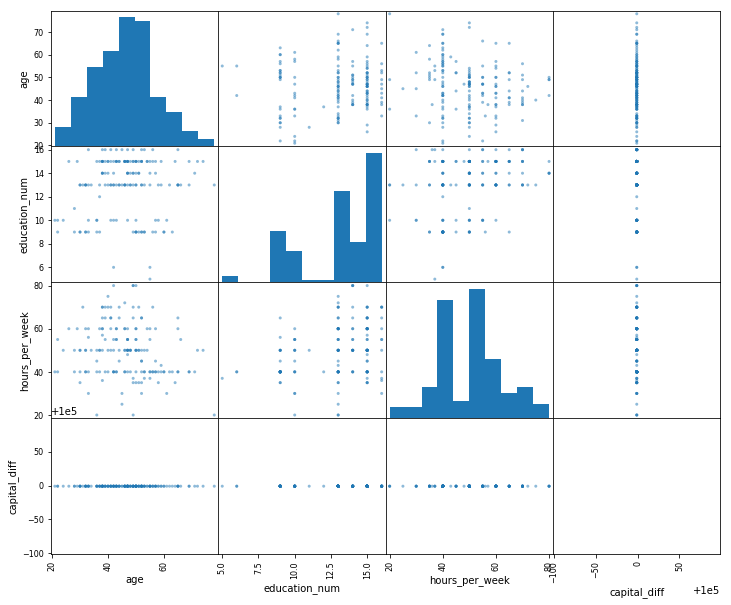

In [12]:
# Now, grab max capital gain individuals
high_gain = my_data.train_df[my_data.train_df.capital_diff == 99999]
# And make a scatter matrix of the the other columns to see the distribution
pd.plotting.scatter_matrix(high_gain, figsize=(12,10))
plt.show()

Looking at the above, it looks like the number of people above age 50 with high capital gain drastically drops, so let's look at this in more detail:

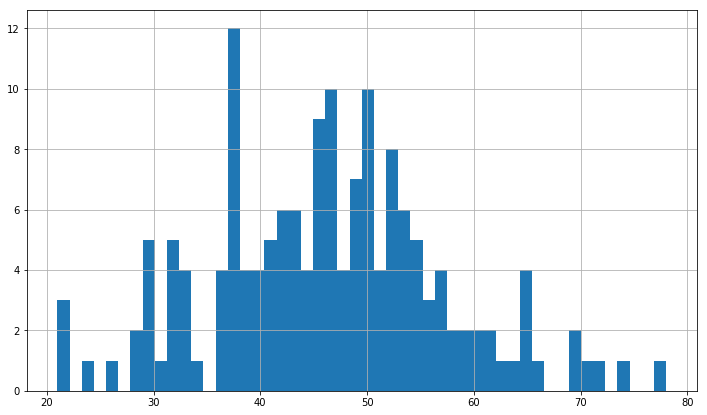

In [13]:
# High Gain vs age
high_gain.age.hist(bins=50, figsize=(12,7))
plt.show()

We see that, indeed, the number of people with capital gain = 99,999 **drops off fairly quickly after age 50, with a small number of individuals below the age of 30**.  This is consistent with the hypothesis that capital gain = 99,999 individuals are those with a house sale, as **young people are unlikely to have a house to sell, and those above a certain age are unlikely to want to sell (and instead, stay in their homes until they retire** -- the data is consistent with this as well, as there is another small bump in indiviuals at age 65, and 70, typical ages of retirement).  Let's now look at how capital gain correlates with education:

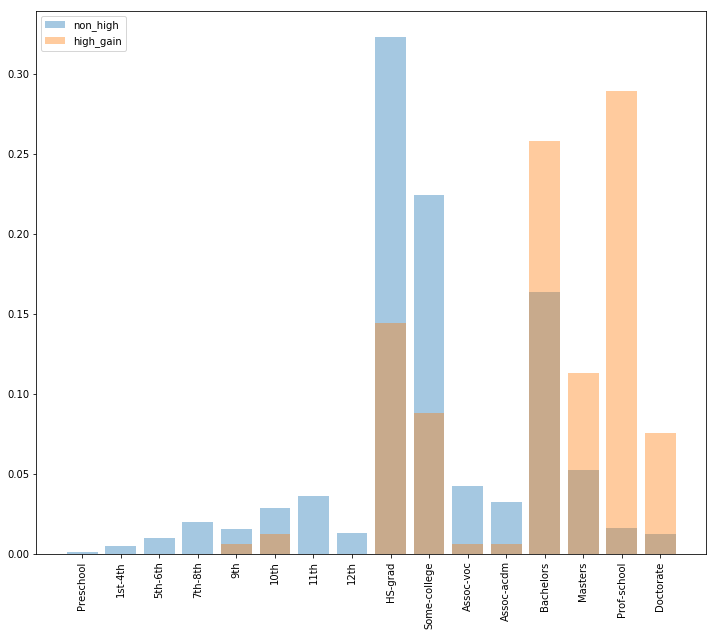

In [14]:
# Grab the different education levels and labels for the levels:
edu_map = my_data.train_df[['education', 'education_num']].drop_duplicates()\
    .sort_values('education_num')
# Also, grab the distribution of education for people with and without a high capital gain.
high_gain_counts = high_gain.education_num.value_counts().sort_index()
non_high_counts = my_data.train_df[my_data.train_df.capital_diff != 99999]\
    ['education_num'].value_counts().sort_index()

# Now, make the bar-charts (normalizing them by the total number of peolple in each category, so we can directly compare distributions)
f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)
ax.bar(non_high_counts.index, non_high_counts.values/ non_high_counts.sum(),
       label='non_high', alpha=0.4)
ax.bar(high_gain_counts.index, high_gain_counts.values / high_gain_counts.sum(),
       label='high_gain', alpha=0.4)
plt.xticks(edu_map.education_num, edu_map.education, rotation='vertical')
plt.legend(loc='upper left')
plt.show()

We clearly see that the **capital gain = 99,999 individuals tend to have a higher education**, although it is surprising how large a fraction of individuals are also included from the high school education only group. This is compared to the non high capital gain group (capital gain != 99,999), which have a markedly larger proportion of individuals with only a high school education.

This observation is also consistent with the hypothesis that high capital gain individuals are likely those that have sold a house, as it is more likely for individuals to have a house that they can sell if they had the education (income) to be able to buy one in the first place.

To further support how this group correlates to income, let's compare with the income group next.

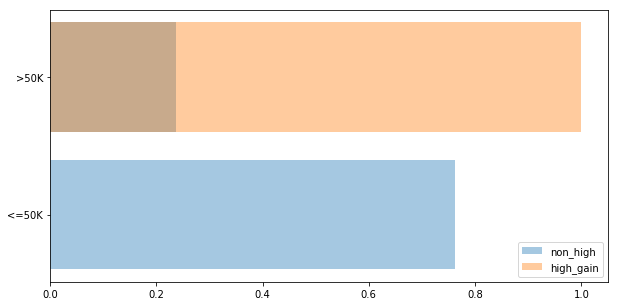

In [15]:
# How does capital gain correlate with income?
high_gain_counts = high_gain.income.value_counts().sort_index()
non_high_counts = my_data.train_df[my_data.train_df.capital_diff != 99999]\
    ['income'].value_counts().sort_index()

# Now, let's make the plot
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.barh(non_high_counts.index, non_high_counts.values/ non_high_counts.sum(),
        label='non_high', alpha=0.4)
ax.barh(high_gain_counts.index, high_gain_counts.values / high_gain_counts.sum(),
        label='high_gain', alpha=0.4)
plt.legend(loc='lower right')
plt.show()

One thing I didn't think of -- perhaps the positive capital gain is claimed as income, so of course high capital gain people would be in the >\$50K earners category.  However, we do see that **for non high captial gain individuals, the vast majority (80%) make less than \$50K**.  So, with all of this, **_I will keep these high capital gain "outliers", as I think these values are real and that the actual value of their house sales were just truncated down to \$99,999_**.  Now, let's take a look at the categorical columns.


#### Categorical Columns Analysis
Recall, that **_workingclass, occupation, and native country_** have NaN values:

In [16]:
# Check which columns have NaN
my_data.get_na_cols('train_df')

Index(['workclass', 'occupation', 'native_country'], dtype='object')

Let's make a plot of these columns to see what the relative distributions look like:

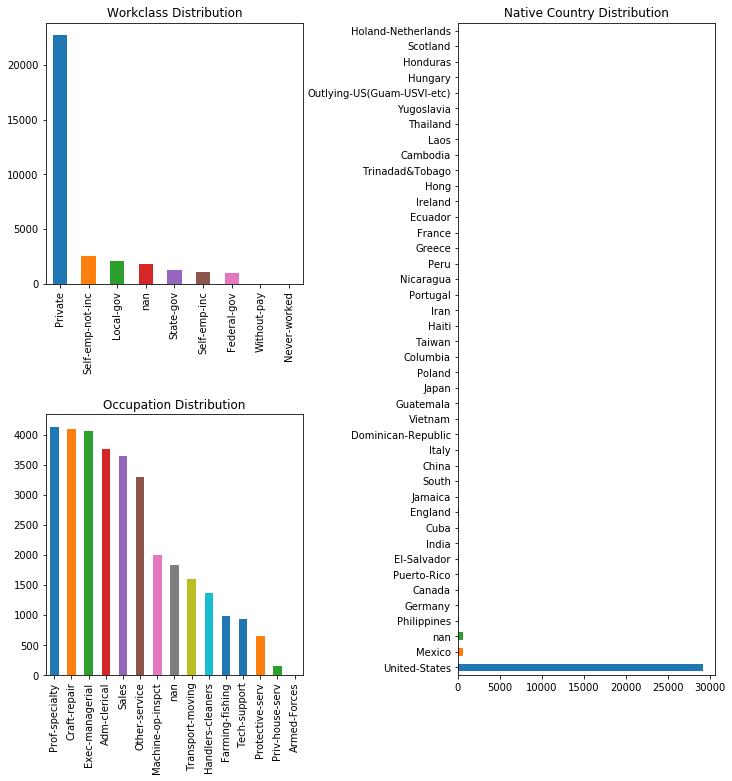

In [17]:
f = plt.figure(figsize=(12,12))
gs = plt.GridSpec(2,2)
gs.update(wspace=0.6, hspace=0.5)
ax = plt.subplot(gs[0,0])
workclass = my_data.train_df.workclass
workclass.value_counts(dropna=False).plot.bar(ax=ax)
ax.set_title('Workclass Distribution')
#plt.show()

# We see that a lot of values are NaN, even more so than the Never-worked
# and without-pay individuals. Let's check for occupation:
occupation = my_data.train_df.occupation
ax = plt.subplot(gs[1,0])
occupation.value_counts(dropna=False).plot.bar(ax=ax)
ax.set_title('Occupation Distribution')
#plt.show()

# We see that the NaNs is again roughly in the middle of the list. And
# finally, for native_country
native_country = my_data.train_df.native_country
ax = plt.subplot(gs[:,1])
native_country.value_counts(dropna=False).plot.barh(ax=ax)
ax.set_title('Native Country Distribution')
plt.show()

We see that the NaN (missing value) population is fairly sizable (the 3rd or 4th most populated category, or within half the list of categories).  So, let's explore how NaN values are related across the categories:

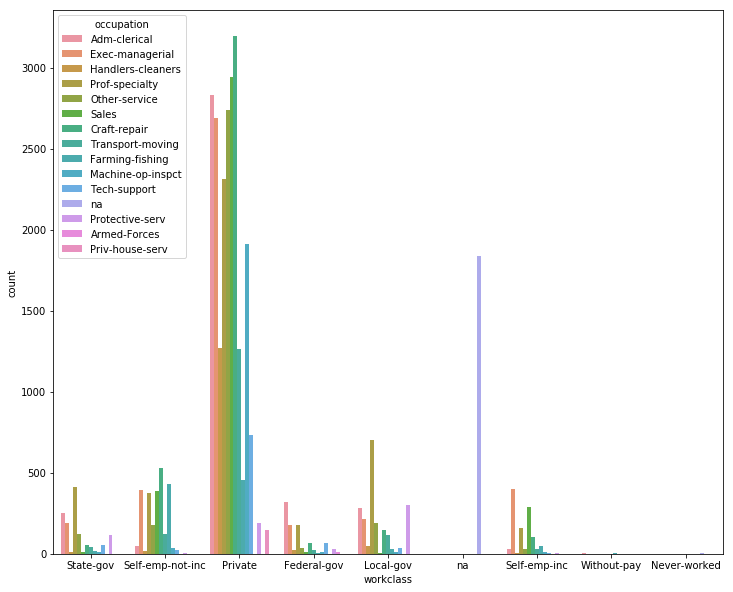

In [18]:
# Show workinglass and occupation counts together
f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)
sns.countplot(x='workclass', hue='occupation', data=my_data.train_df.fillna('na'), ax=ax)
plt.show()

From above, we see that the **only individuals with missing information in workclass also are missing information in occupation, and vice versa**.  Let's verify this:

In [19]:
print("Number missing from Workclass: ", my_data.train_df.workclass.isna().sum())
print("Number missing from Occupation: ", my_data.train_df.occupation.isna().sum())
print("Number missing from both: ", (my_data.train_df.workclass.isna() &
                                     my_data.train_df.occupation.isna()).sum())

Number missing from Workclass:  1836
Number missing from Occupation:  1843
Number missing from both:  1836


We see that the individuals with missing information in Workclass are a subset of those with missing information in Occupation, with Occupation having 7 more individuals with missing information in this category.

In [20]:
print("Number missing from Native Country: ",
      my_data.train_df.native_country.isna().sum())
print("Number missing from Native Country and Occupation: ",
      (my_data.train_df.native_country.isna() & my_data.train_df.occupation.isna()).sum())
print("Number missing from Native Country, Occupation, and Workclass: ",
      (my_data.train_df.native_country.isna() & my_data.train_df.occupation.isna()
       & my_data.train_df.workclass.isna()).sum())

Number missing from Native Country:  583
Number missing from Native Country and Occupation:  27
Number missing from Native Country, Occupation, and Workclass:  27


So, we see that from the ~1836 individuals that are missing information from Workclass/ Occupation, only 27 (~1.5%) are also missing information from their native country.  This is compared to the 583 indivduals with missing information about their native country, where ~4.6% are also missing work class/ occupation information. **Due to limited time, I just categorized the values in these columns for these individuals as "NaN", since I thought it could be significant _why_ they _chose_ to leave these questions blank in their survey, and there are different reasons operating for those who left native country blank from those who left workclass/ occupation blank**.

In [21]:
my_data.train_df.loc[workclass.isnull(), 'workclass'] = 'NaN'
my_data.train_df.loc[occupation.isnull(), 'occupation'] = 'NaN'
my_data.train_df.loc[native_country.isnull(), 'native_country'] = 'NaN'

##### **_Consolodate Category columns_**:
First, let's look at native country (since we had a lot of values for this columns) and how this relates to income.

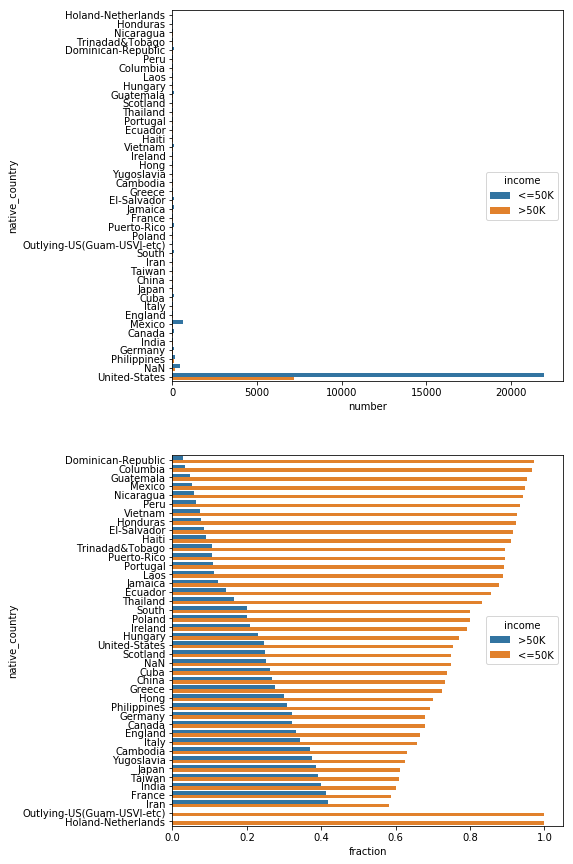

In [22]:
f = plt.figure(figsize=(7,15))
ax = f.add_subplot(211)
df = my_data.train_df.groupby('native_country')['income'].value_counts(dropna=False)\
    .rename('number').reset_index().sort_values('number')
sns.barplot(y='native_country', x='number', hue='income', data=df, ax=ax)
#plt.xticks(rotation=90)

ax = f.add_subplot(212)
df = my_data.train_df.groupby('native_country')['income']\
    .value_counts(normalize=True, dropna=False).rename('fraction').reset_index()\
    .sort_values('fraction')
sns.barplot(y='native_country', x='fraction', hue='income', data=df, ax=ax)
#plt.xticks(rotation=90)
plt.show()

Although we see quite the spread in terms of the relative number of people at each income level (2nd plot), **There are _drastically_ more people in from the US, Mexico, and NaN, so I will consolodate to these countries and "Other"**.

Looking at workingclass with respect to income:

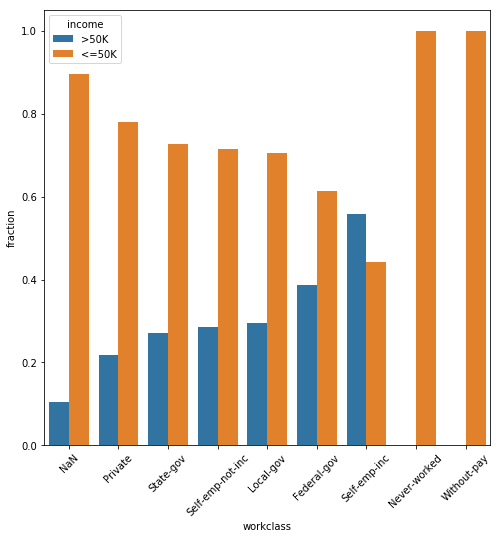

In [23]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(111)
df = my_data.train_df.groupby('workclass')['income'].value_counts(normalize=True)\
    .rename('fraction').reset_index().sort_values('fraction')
sns.barplot(x='workclass', y='fraction', hue='income', data=df, ax=ax)
plt.xticks(rotation=45)
plt.show()

We see:
1. **Local and state government** individuals have similar income distributions, but **federal** isn't too far off, so **let's put them in the same category**.
2. The **never-worked and without-pay** individuals are both likely unemployed, so **let's combine them**.

And for Occupation:

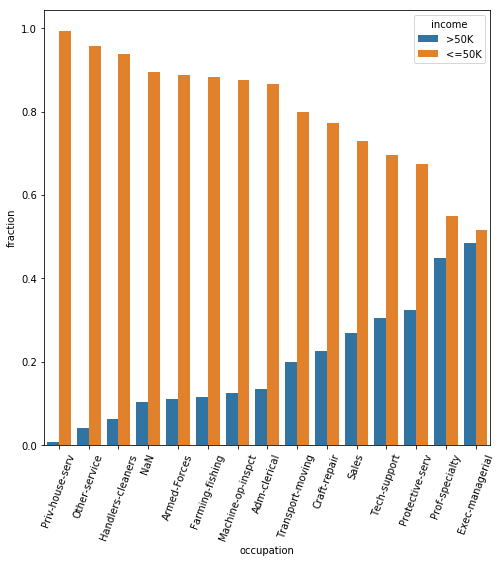

In [24]:
f= plt.figure(figsize=(8,8))
ax = f.add_subplot(111)
df = my_data.train_df.groupby('occupation')['income'].value_counts(normalize=True)\
    .rename('fraction').reset_index().sort_values('fraction')
sns.barplot(hue='income', y='fraction', x='occupation', data=df, ax=ax)
plt.xticks(rotation=70)
plt.show()

Here, we have a lot more categories of occupations.  Let's consolodate them, based on what people might traditionally group them as (this keeps "Sales" as it's own category):
* as "Service":
 - Priv-house-serv
 - Other-service
* as "Blue_collar"
 - Handlers-cleaners
 - Farming-fishing
 - Machine-op-inspct
 - Transport-moving
 - Craft-repair
* as "Military"
 - Armed-Forces
* as "Admin"
 - Adm-clerical
* as "Other_ocupation"
 - Tech-support
 - Protective-serv
* as "White_collar"
 - Prof-specialty
 - Exec-managerial

Now, looking at the education column:

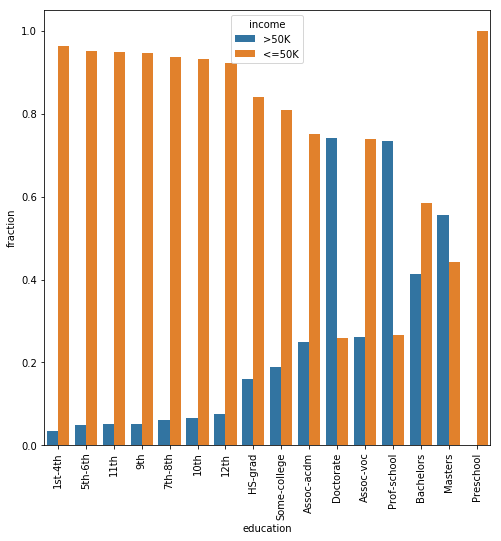

In [25]:
f= plt.figure(figsize=(8,8))
ax = f.add_subplot(111)
df = my_data.train_df.groupby('education')['income'].value_counts(normalize=True)\
    .rename('fraction').reset_index().sort_values('fraction')
sns.barplot(hue='income', y='fraction', x='education', data=df, ax=ax)
plt.xticks(rotation=90)
plt.show()

We see we can definitely consolodate this column:
* "Dropout"
  - Preschool 1st-4th 5th-6th 7th-8th 9th 10th 11th 12th
* "HS_grad"
  - HS-grad Some-college
* "Associates"
  - Assoc-acdm Assoc-voc
  
Now, for the remaining categorical columns:

In [26]:
nominal_counts = pd.DataFrame()
for col in 'marital_status relationship race'.split():
    nominal_counts = pd.merge(
        nominal_counts,
        my_data.train_df[col].value_counts(dropna=False).reset_index()\
            .rename(columns={'index': col, col: (col + '_cnt')}),
        how='outer', left_index=True, right_index=True)

# Note, NaN values in nominal counts are only because there are less unique
# values for these categories than the other columns
nominal_counts

,marital_status,marital_status_cnt,relationship,relationship_cnt,race,race_cnt
0,Married-civ-spouse,14976,Husband,13193.0,White,27816.0
1,Never-married,10683,Not-in-family,8305.0,Black,3124.0
2,Divorced,4443,Own-child,5068.0,Asian-Pac-Islander,1039.0
3,Separated,1025,Unmarried,3446.0,Amer-Indian-Eskimo,311.0
4,Widowed,993,Wife,1568.0,Other,271.0
5,Married-spouse-absent,418,Other-relative,981.0,NaN,NaN
6,Married-AF-spouse,23,NaN,NaN,NaN,NaN


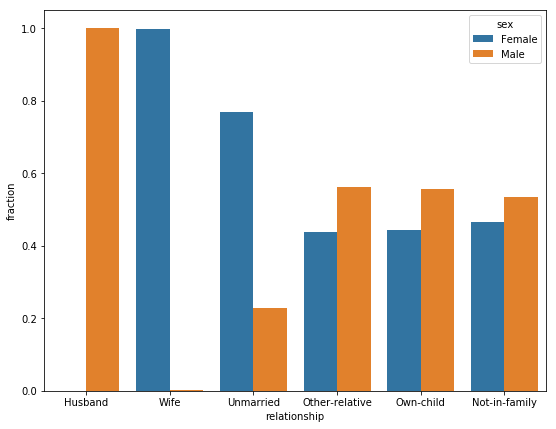

In [27]:
# Let's take a look at the relationshiop column in greater detail -- in particular,
# how this relates to gender
f = plt.figure(figsize=(9,7))
ax = f.add_subplot(111)
df = my_data.train_df.groupby('relationship')['sex']\
    .value_counts(normalize=True).rename('fraction').reset_index()\
    .sort_values('fraction')
sns.barplot(hue='sex', y='fraction', x='relationship', data=df, ax=ax)
plt.show()

I would have **thought that Own-child would mean a single-parent**, and so would have a higher number of women, but this doesn't seem to be the case. Also, I would have **thought Unmarried would mean people that are living together, but aren't married** (as opposed to Not-in-family) but we see many more women in this category, so that can't be the case either.  **_Since it's hard to decipher what the attributes mean, let's leave this column alone_**.

As for the **race column, I'll shorten some of the values** some ("Asian-Pac-Islander" to "Asian" and "Amer-Indian-Eskimo" to "Amer_Indian"), but otherwise, leave it untouched.

Finally, for the marital status column, we have:

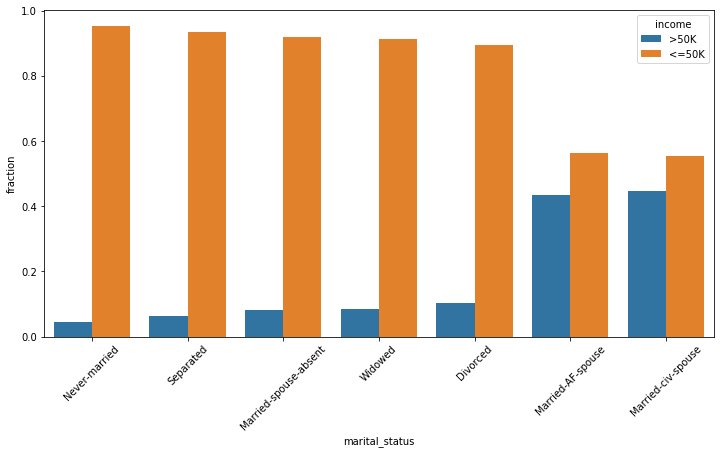

In [28]:
# See the income distribution for each marital status
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(111)
df = my_data.train_df.groupby('marital_status')['income']\
    .value_counts(normalize=True).rename('fraction').reset_index()\
    .sort_values('fraction')
sns.barplot(hue='income', y='fraction', x='marital_status', data=df, ax=ax)
plt.xticks(rotation=45)
plt.show()

From this, we definitely see that **marriage seems to be good** with respect to improving an individual's earnings, and, there seem to be some natural groupings of the categories:
* "Broken_marriage"
  - Separated, Married-spouse-absent, Divorced
* "Married"
  - Married-AF-spuse, Married-civ-spouse
* "Never_married"
* "Widowed"

To check if marriage is really good for individuals, let's break these apart by gender:

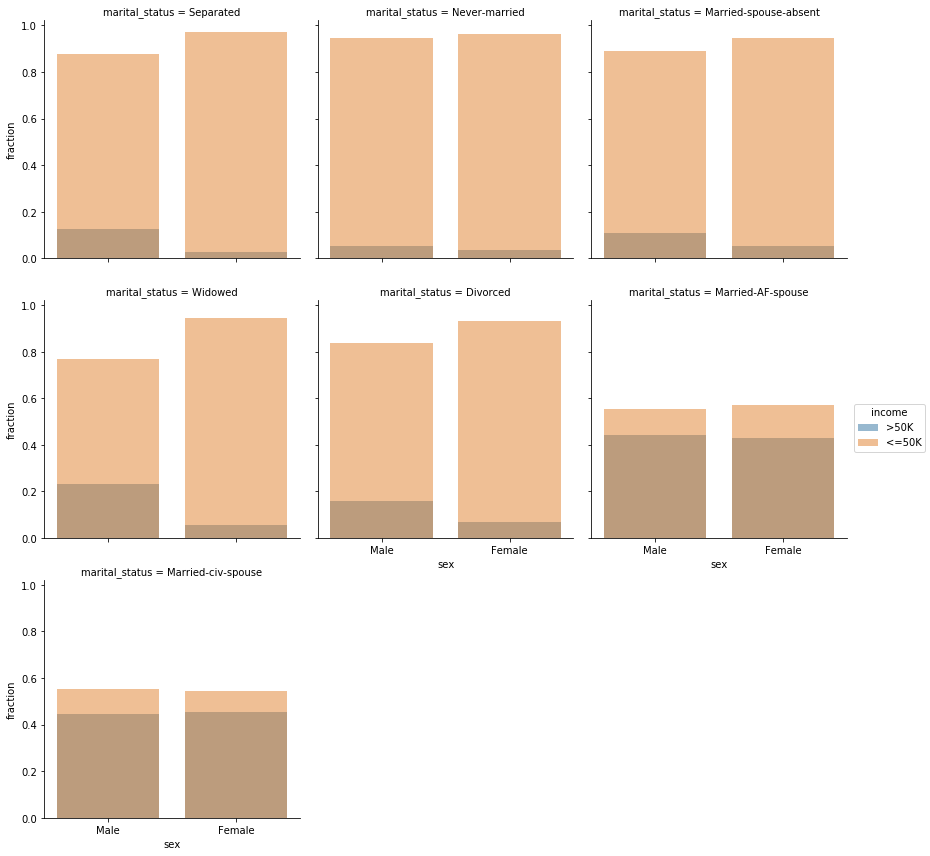

In [29]:
# Now, add Gender into the mix
df = my_data.train_df.groupby('marital_status sex'.split())['income']\
    .value_counts(normalize=True).rename('fraction').reset_index()\
    .sort_values('fraction')
g = sns.FacetGrid(data=df, hue='income', col='marital_status', hue_order=['>50K', '<=50K'], col_wrap=3, size=4)
g = g.map(sns.barplot, 'sex', 'fraction', alpha=0.5, order=['Male', 'Female'])
g.add_legend()
plt.show()

Here, we see that there is **gender inequalities in income across the board**, but these inequalities seem to be the smallest for married individuals.  Considering how different the married numbers are, I suspect **perhaps what is given is not individual income, but perhaps the joint household income**.  In any case, since we don't have actual income values, we can't really do much more with this dataset.

### Feature Engineering
I won't show it here, but let's use **min-max scaling for numeric columns**, and **create dummy variables of the categorical columns**.  The one **exception is the education column, which is ordinal**, so we will leave it a string of integers based on education level: **0-6 for the order Dropout, HS_grad, Associates, Bachelors, Masters, Prof-school, Doctorate**

In [30]:
# Completed Class, with all feature cleanup/ engineering, with a few extra methods built in to help with classification:
class DataProject(object):
    """
    Just use a class to group all methods together, especially if we're going
    to be building on our work through each assignment.
    """

    def __init__(self, train, test, head):
        """Initialize the class when we instantiate it.

        Args:
            train (str): URL of the training set data
            test (str): URL of the test set data
            head (str): URL of the header location

        Attributes:
            self.train_url = train
            self.test_url = test
            self.head_url = head
            self.train_df = pd.DataFrame of trainig Data
            self.test_df = pd.DataFrame of the test Data
            self.train_X/Y = pd.DataFrame of the training features/ labels
                (unscaled numeric columns dropped, education column
                    (pd.category) converted to int)
            self.test_X/Y = pd.DataFrame of the test features/ labels (unscaled
                numeric columns dropped, education column (pd.category)
                converted to int)
        """

        # Save the URL's, in case we want it later
        self.train_url = train
        self.test_url = test
        self.head_url = head

        # Grab the data, and store the internal variables
        self._get_data()

        # Clean the numeric data
        self._clean_numeric_data()

        # Now, clean the categorical columns
        self._clean_categorical_data()

        # Normalize the numeric data
        self._normalize_numerics()

        # And curate the columns to drop redundant dummy columns
        self._curate_columns()

        # Build the ML arrays
        self._make_ml_data()


    def _get_data(self):
        """"Internal method to get the data and associate it with the class.
        Used in self.__init__
        """

        # Grab the data. Note, the separator is actually ', ', not just a
        # comma, so specify. Also, recognize the "?" as an NA value
        # (I think it is easier to have pandas catch the NA values instead
        #  of manually searching for and parsing these in the future).
        # Finally, set the engine to python, since having a separator greater
        # than one character automatically does this, and prints a warning
        # message.  By explicitly telling it to use python, we suppress the
        # warning.
        self.train_df = pd.read_csv(self.train_url, sep=', ', header=None,
                                    na_values='?', engine='python')

        # For the training data, have one comment row, so need to ignore
        self.test_df = pd.read_csv(self.test_url, sep=', ', header=None,
                                   skiprows=1, na_values='?', engine='python')

        # Get the header data
        response = requests.get(self.head_url)
        header = response.text.split('\n')

        # Now, filter to grab the header lines:
        # First, make sure there is at least one character for the line, and
        # ignore lines that start with the comment character for the file "|"
        header = [row for row in header if len(row) > 0 and row[0] != '|']

        # Ignore the first row, since it is just identifying the classifier
        # task and, get just the header values
        header = [head.split(':')[0] for head in header[1:]]

        # Finally, we need to add a header name for the last column (if <= or >
        # income of 50k)
        header.append('income')

        # Since it's hard to access df elements if they have a '-' (we have
        # to explicitly use df[colname] notation, instead of just df.colname)
        # let's convert all hyphens in column names into underscores
        header = ['_'.join(col.split('-')) for col in header]

        # Now, set the header for the data sets
        self.train_df.columns = header
        self.test_df.columns = header

    def _clean_numeric_data(self):
        """Consolidate the work done to clean the numeric columns. Acts on:
        self.train_df and self.test_df.
        """

        # We saw that capital_gain and capital_loss is only != 0 if the other
        # = 0. So, let's collapse these columns
        self.train_df.loc[:,'capital_diff'] = (
            self.train_df.capital_gain - self.train_df.capital_loss)
        self.test_df.loc[:,'capital_diff'] = (
            self.test_df.capital_gain - self.test_df.capital_loss)

        # And, drop the original capital gain/ capital loss columns
        self.train_df.drop('capital_gain capital_loss'.split(), axis=1,
                            inplace=True)
        self.test_df.drop('capital_gain capital_loss'.split(), axis=1,
                            inplace=True)

    def _clean_categorical_data(self):
        """Cleanup the categorical data, using all the methods we did in
        Lesson 6.
        """

        # Replace the missing data with "NaN"s, since we think there
        # are good reasons why people chose not to provide these
        # pieces of information
        workclass = self.train_df.workclass
        occupation = self.train_df.occupation
        native_country = self.train_df.native_country
        self.train_df.loc[workclass.isnull(), 'workclass'] = 'NaN'
        self.train_df.loc[occupation.isnull(), 'occupation'] = 'NaN'
        self.train_df.loc[native_country.isnull(), 'native_country'] = 'NaN'

        # And for the test data
        workclass = self.test_df.workclass
        occupation = self.test_df.occupation
        native_country = self.test_df.native_country
        self.test_df.loc[workclass.isnull(), 'workclass'] = 'NaN'
        self.test_df.loc[occupation.isnull(), 'occupation'] = 'NaN'
        self.test_df.loc[native_country.isnull(), 'native_country'] = 'NaN'

        # Consolodate the native country field to US, Mexico, NaN, and Other
        countries = 'United-States Mexico NaN'.split()
        self.train_df.loc[~self.train_df.native_country.isin(countries),
                          'native_country'] = 'Other'

        # And for the test data
        self.test_df.loc[~self.test_df.native_country.isin(countries),
                          'native_country'] = 'Other'

        # Consolodate the workinglass values
        self.train_df.loc[
            self.train_df.workclass.isin(
                'Local-gov State-gov Federal-gov'.split()), 'workclass'] = 'Gov'
        self.train_df.loc[
            self.train_df.workclass.isin(
                'Without-pay Never-worked'.split()), 'workclass'] = 'Unemployed'

        # And for the test data
        self.test_df.loc[
            self.test_df.workclass.isin(
                'Local-gov State-gov Federal-gov'.split()), 'workclass'] = 'Gov'
        self.test_df.loc[
            self.test_df.workclass.isin(
                'Without-pay Never-worked'.split()), 'workclass'] = 'Unemployed'

        # Consolodate the occupation column, based off of groupings people
        # frequently make.
        self.train_df.loc[
            self.train_df.occupation.isin(
                'Priv-house-serv Other-service'.split()), 'occupation'] = (
                'Service')
        self.train_df.loc[
            self.train_df.occupation.isin(
                ('Handlers-cleaners Farming-fishing Machine-op-inspct '
                'Transport-moving Craft-repair').split()), 'occupation'] = (
                    'Blue_collar')
        self.train_df.loc[
            self.train_df.occupation.isin(
                'Armed-Forces'.split()), 'occupation'] = 'Military'
        self.train_df.loc[
            self.train_df.occupation.isin(
                'Adm-clerical'.split()), 'occupation'] = 'Admin'
        self.train_df.loc[
            self.train_df.occupation.isin(
                'Tech-support Protective-serv'.split()), 'occupation'] = (
                    'Other_ocupation')
        self.train_df.loc[
            self.train_df.occupation.isin(
                'Prof-specialty Exec-managerial'.split()), 'occupation'] = (
                    'White_collar')

        # And for the test data
        self.test_df.loc[
            self.test_df.occupation.isin(
                'Priv-house-serv Other-service'.split()), 'occupation'] = (
                    'Service')
        self.test_df.loc[
            self.test_df.occupation.isin(
                ('Handlers-cleaners Farming-fishing Machine-op-inspct '
                'Transport-moving Craft-repair').split()), 'occupation'] = (
                    'Blue_collar')
        self.test_df.loc[
            self.test_df.occupation.isin(
                'Armed-Forces'.split()), 'occupation'] = 'Military'
        self.test_df.loc[
            self.test_df.occupation.isin(
                'Adm-clerical'.split()), 'occupation'] = 'Admin'
        self.test_df.loc[
            self.test_df.occupation.isin(
                'Tech-support Protective-serv'.split()), 'occupation'] = (
                    'Other_ocupation')
        self.test_df.loc[
            self.test_df.occupation.isin(
                'Prof-specialty Exec-managerial'.split()), 'occupation'] = (
                    'White_collar')

        # Drop the education_num column since the education column contains the
        # same information, and we want to condense the values somewhat
        self.train_df.drop('education_num', axis=1, inplace=True)
        self.test_df.drop('education_num', axis=1, inplace=True)

        # Now, group the different types of education people had based on HS
        # graduation or not, and a few other groupings
        self.train_df.loc[
            self.train_df.education.isin(
                'Preschool 1st-4th 5th-6th 7th-8th 9th 10th 11th 12th'.split()),
            'education'] = 'Dropout'
        self.train_df.loc[
            self.train_df.education.isin(
                'HS-grad Some-college'.split()), 'education'] = 'HS_grad'
        self.train_df.loc[
            self.train_df.education.isin(
                'Assoc-acdm Assoc-voc'.split()), 'education'] = 'Associates'

        # and for the test data
        self.test_df.loc[
            self.test_df.education.isin(
                'Preschool 1st-4th 5th-6th 7th-8th 9th 10th 11th 12th'.split()),
            'education'] = 'Dropout'
        self.test_df.loc[
            self.test_df.education.isin(
                'HS-grad Some-college'.split()), 'education'] = 'HS_grad'
        self.test_df.loc[
            self.test_df.education.isin(
                'Assoc-acdm Assoc-voc'.split()), 'education'] = 'Associates'

        # Rename the a few race values to make them easier to access later
        self.train_df.loc[
            self.train_df.race == 'Asian-Pac-Islander', 'race'] = 'Asian'
        self.train_df.loc[
            self.train_df.race == 'Amer-Indian-Eskimo', 'race'] = 'Amer_Indian'

        # And on the test data
        self.test_df.loc[
            self.test_df.race == 'Asian-Pac-Islander', 'race'] = 'Asian'
        self.test_df.loc[
            self.test_df.race == 'Amer-Indian-Eskimo', 'race'] = 'Amer_Indian'

        # Now, let's fix the marital_status column
        self.train_df.loc[
            self.train_df.marital_status.isin(
                'Separated Married-spouse-absent Divorced'.split()),
            'marital_status'] = 'Broken_marriage'
        self.train_df.loc[
            self.train_df.marital_status.isin(
                'Never-married'.split()), 'marital_status'] = 'Never_married'
        self.train_df.loc[
            self.train_df.marital_status.isin(
                'Married-AF-spouse Married-civ-spouse'.split()),
            'marital_status'] = 'Married'

        # And for the test data
        self.test_df.loc[
            self.test_df.marital_status.isin(
                'Separated Married-spouse-absent Divorced'.split()),
            'marital_status'] = 'Broken_marriage'
        self.test_df.loc[
            self.test_df.marital_status.isin(
                'Never-married'.split()), 'marital_status'] = 'Never_married'
        self.test_df.loc[
            self.test_df.marital_status.isin(
                'Married-AF-spouse Married-civ-spouse'.split()),
            'marital_status'] = 'Married'

        # Now, create dummy variables
        cols = self.train_df.select_dtypes(include=['object']).columns.tolist()

        # Then remove the education column from this list
        cols.remove('education')

        # Now, for the remaining columns, lets make dummy columns
        self.train_df = pd.merge(
            self.train_df,
            pd.get_dummies(
                self.train_df[cols], prefix=cols, columns=cols),
            right_index=True, left_index=True, how='outer')

        # And delete the columns we no longer need
        self.train_df.drop(cols, axis=1, inplace=True)

        # Repeate for the test data
        self.test_df = pd.merge(
            self.test_df,
            pd.get_dummies(
                self.test_df[cols], prefix=cols, columns=cols),
            right_index=True, left_index=True, how='outer')
        self.test_df.drop(cols, axis=1, inplace=True)

        # Now, create the category list/ order for the education column
        education_categories = ['Dropout', 'HS_grad', 'Associates', 'Bachelors',
                                'Masters', 'Prof-school', 'Doctorate']

        # And, set the category type for the education column with these values
        self.train_df.education = pd.Categorical(
            self.train_df.education, categories=education_categories,
            ordered=True
        )
        self.test_df.education = pd.Categorical(
            self.test_df.education, categories=education_categories,
            ordered=True
        )

        # Fix the test_df income columns (data had a period at the end of the
        # values)
        self.test_df.rename({'income_<=50K.': 'income_<=50K',
                             'income_>50K.': 'income_>50K'}, axis='columns',
                            inplace=True)

    def _normalize_numerics(self):
        """Normalize the numeric columns of the dataframes.
        """

        # 'fnlwgt' is still a feature in the dataframe -- it is a scaling
        # factor to relate the row to the population.  Since there isn't a
        # whole lot of documentation on what exactly this means, let's
        # actually drop this column from our dataset
        self.train_df.drop('fnlwgt', axis=1, inplace=True)
        self.test_df.drop('fnlwgt', axis=1, inplace=True)

        # We see that the non-dummy_variable columns are of type int64
        # (longlong) so use that to grab these column names
        cols = self.train_df.select_dtypes(include=['longlong']).columns\
            .tolist()

        # And apply min-max scaling to each of these columns. Call them
        # "scaled_***"
        for name in cols:
            minmax_scale = MinMaxScaler().fit(self.train_df[name].to_frame())
            self.train_df['scaled_' + name] = minmax_scale.transform(
                self.train_df[name].to_frame()
            )
            self.test_df['scaled_' + name] = minmax_scale.transform(
                self.test_df[name].to_frame()
            )

    def _curate_columns(self):
        """Drop the extra dummy columns that we don't need, since they contain
        redundant information.
        """

        # Create list to drop some:
        drop_col = [
            'workclass_Unemployed',
            'marital_status_Never_married',
            'occupation_NaN',
            'relationship_Not-in-family',
            'race_Other',
            'sex_Male',
            'native_country_NaN',
            'income_<=50K'
        ]

        # Now, drop these columns:
        self.train_df.drop(drop_col, axis='columns', inplace=True)
        self.test_df.drop(drop_col, axis='columns', inplace=True)

    def get_na_cols(self, df):
        """Get columns with null values from the specified dataframe that
        are associated with this class
        
        Args:
            df (str): Name of the dataframe associated with this class instance
                For example, if the instance of this class is mydata,
                then check if mydata.train_df has any columns with null values
                by calling mydata.get_na_cols('train_df')

        Returns:
            pd.Index: A pd.Index object with all the column names that have
                a null value.
        """

        # Make sure we are given a string
        assert type(df) == str, 'Need to give a string!'

        # Try to get this dataframe from this class
        try:
            df = getattr(self, df)

            # Assert that what we got is indeed a pd.DataFrame
            assert type(df) is pd.core.frame.DataFrame, "Didn't grab a df!"

        except AttributeError:
            print("\"{}\" isn't a part of the class!".format(df))
            raise

        # Now, return columns with a null
        return df.columns[df.isnull().any()]

    def _make_ml_data(self):
        """Construct self.train/test_X/Y based on the dataframes. Also, further
        curate the dataframe columns to remove unscaled numeric columns.
        """

        # Copy the train/test data
        self.train_X = self.train_df.copy(deep=True)
        self.test_X = self.test_df.copy(deep=True)

        # Now, drop the unscaled version of the numeric columns:
        drop_col = ['age', 'hours_per_week', 'capital_diff']
        self.train_X.drop(drop_col, axis='columns', inplace=True)
        self.test_X.drop(drop_col, axis='columns', inplace=True)

        # Also, sklearn needs numerical values, so convert the Education column
        # to the integer equivalent of the categories
        self.train_X.education = self.train_X.education.cat.codes
        self.test_X.education = self.test_X.education.cat.codes

        # Now, set the ml data
        self.train_Y = self.train_X['income_>50K']
        self.train_X = self.train_X.drop('income_>50K', axis='columns')
        
        self.test_Y = self.test_X['income_>50K']
        self.test_X = self.test_X.drop('income_>50K', axis='columns')

    def setup_RandomForest(self, **kwargs):
        """Set up a random forest classifier based on any input parameters
        given in **kwargs, and fit to the training data.

        Sets up Attribute
        self.rfc = sklearn.RandomForest classifier, with .fit() run on training
            data.
        """

        # Instantiate the classifier
        self.rfc = RandomForestClassifier(**kwargs)

        # And fit to the training data
        self.rfc.fit(self.train_X, self.train_Y)

    def setup_GaussianNB(self, **kwargs):
        """Set up a Gaussian Naive Bayes classifier based on input parameters
        given in **kwargs, and fit to the training data

        Sets up attribute
        self.nbc = sklearn.naive_bayes.GaussianNB classifier with .fit() run on
            training data.
        """

        # Instantiate the classifier
        self.nbc = GaussianNB(**kwargs)

        # Fit to the training data
        self.nbc.fit(self.train_X, self.train_Y)

In [31]:
# Instantiate the class again:
my_data = DataProject(TRAIN_URL, TEST_URL, HEADER_URL)

### Algorithm
Random forest and Gaussian naive bayes

In [32]:
# Set up and fit the Random Forest classifier
my_data.setup_RandomForest(n_estimators=20, random_state=0)

# And the Naive Bayes classifier (we don't have any information about
# priors, so leave blank)
my_data.setup_GaussianNB()

# Now, predict, the test set, and create a dataframe that shows
# predictions vs actual
results = pd.DataFrame({
    'RF_predict': my_data.rfc.predict(my_data.test_X),
    'NB_predict': my_data.nbc.predict(my_data.test_X),
    'actual': my_data.test_Y
})
results.head()

,NB_predict,RF_predict,actual
0,0,0,0
1,1,0,0
2,1,0,1
3,1,1,1
4,0,0,0


### Evaluation of Classifiers
First, let's take a look at the confusion matrix

In [33]:
# Raw confusion Matricies:
print("RF Confusion Matrix:\n", skm.confusion_matrix(results.actual, results.RF_predict), sep='')
print("NB Confusion Matrix:\n", skm.confusion_matrix(results.actual, results.NB_predict), sep='')

RF Confusion Matrix:
[[11419  1016]
 [ 1556  2290]]
NB Confusion Matrix:
[[8537 3898]
 [ 454 3392]]


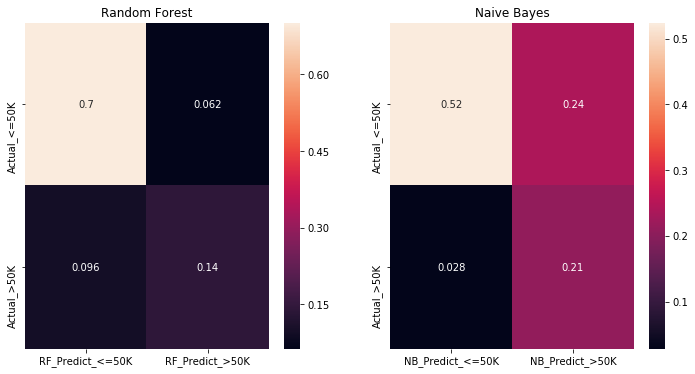

In [34]:
# Normalized Graphical form:
RF_con_matrix = pd.DataFrame(
    skm.confusion_matrix(results.actual, results.RF_predict),
    index=['Actual_<=50K', 'Actual_>50K'],
    columns=['RF_Predict_<=50K', 'RF_Predict_>50K'])
NB_con_matrix = pd.DataFrame(
    skm.confusion_matrix(results.actual, results.NB_predict),
    index=['Actual_<=50K', 'Actual_>50K'],
    columns=['NB_Predict_<=50K', 'NB_Predict_>50K'])

# Normalize by the total, so we get a fraction of all cases per cell
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(121)
sns.heatmap(RF_con_matrix/RF_con_matrix.sum().sum(), annot=True, ax=ax)
ax.set_title('Random Forest')
ax = f.add_subplot(122)
sns.heatmap(NB_con_matrix/NB_con_matrix.sum().sum(), annot=True, ax=ax)
ax.set_title('Naive Bayes')
plt.show()

See both methods seem do a better job at identifying non-high earners (I'm assuming because there were more instances of <=50K individuals, so the algorithms were able to learn their characterisics better), but it does seem the Random Forest classifier is doing a better job (the top right and bottom left diagonals are darker, although it didn't identify as many people in the true positive category).  In reality, we need the relative values of these quadrants with respect to their rows (sensitivity and specificity), or other metrics.  For these other metrics, we have:

In [35]:
RF_AR = skm.accuracy_score(results.actual, results.RF_predict)
NB_AR = skm.accuracy_score(results.actual, results.NB_predict)
#print("Random Forest Accuracy:", RF_AR, "\nNaive Bayes Accuracy:", NB_AR)

# We get more details if we look at Sensitivity and Specificity
# (TPR and 1-FPR)
rf_tn, rf_fp, rf_fn, rf_tp = RF_con_matrix.values.ravel()
nb_tn, nb_fp, nb_fn, nb_tp = NB_con_matrix.values.ravel()

rf_sensitivity = rf_tp/(rf_tp+rf_fn)
rf_specificity = rf_tn/(rf_tn+rf_fp)
nb_sensitivity = nb_tp/(nb_tp+nb_fn)
nb_specificity = nb_tn/(nb_tn+nb_fp)
pd.DataFrame([[RF_AR, rf_sensitivity, rf_specificity], [NB_AR, nb_sensitivity, nb_specificity]],
             columns=['Accuracy', 'Sensitivity', 'Specificity'], index=['RandomForest', 'NaiveBayes'])

,Accuracy,Sensitivity,Specificity
RandomForest,0.842024,0.595424,0.918295
NaiveBayes,0.732695,0.881955,0.686530


So, at least at this level, the Random Forest classifier does indeed seem to be doing a better job, but it isn't as good at distinguishing true positives.  Let's check out the classifiers as a whole to see if there is one we would prefer to pick over the other using an ROC curve:

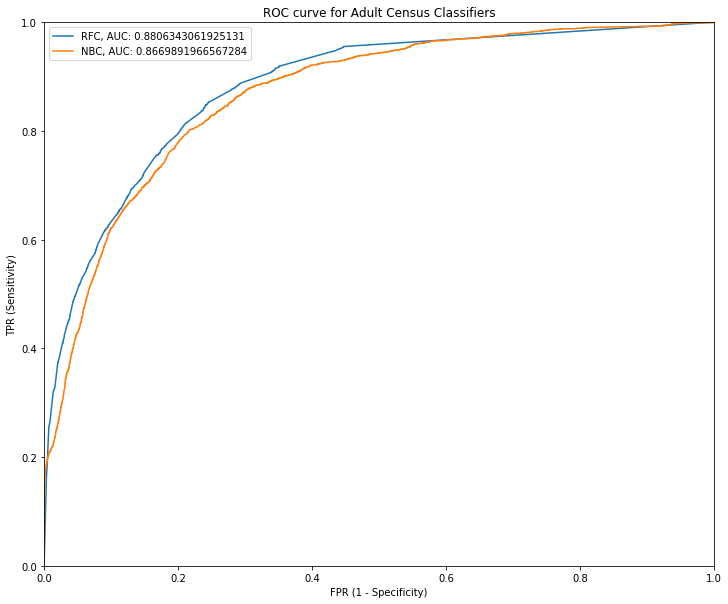

In [36]:
rf_predict_prob = my_data.rfc.predict_proba(my_data.test_X)[:, 1]
nb_predict_prob = my_data.nbc.predict_proba(my_data.test_X)[:, 1]
rf_fpr, rf_tpr, rf_thresholds = skm.roc_curve(results.actual,
                                              rf_predict_prob)
nb_fpr, nb_tpr, nb_thresholds = skm.roc_curve(results.actual,
                                              nb_predict_prob)

rf_auc_score = skm.roc_auc_score(results.actual, rf_predict_prob)
nb_auc_score = skm.roc_auc_score(results.actual, nb_predict_prob)

f = plt.figure(figsize=(12,10))
ax = f.add_subplot(111)
plt.plot(rf_fpr, rf_tpr, label='RFC, AUC: {}'.format(rf_auc_score))
plt.plot(nb_fpr, nb_tpr, label='NBC, AUC: {}'.format(nb_auc_score))
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC curve for Adult Census Classifiers')
plt.xlabel('FPR (1 - Specificity)')
plt.ylabel('TPR (Sensitivity)')

plt.show()

So, it looks like, for the vast majority of thresholds, the Random forest classifier is indeed a better option.  Let's see what an "optimum" threshold for both might be (one that maximizes sensitivity and specificity), and what sensitivity/ specificity values we get.

In [37]:
# First, make it easier to work with the respective quantities for each classifier:
rf_metrics = pd.DataFrame({
    'rf_sensitivity': rf_tpr,
    'rf_specificity': (1-rf_fpr),
    'rf_threshold': rf_thresholds})
nb_metrics = pd.DataFrame({
    'nb_sensitivity': nb_tpr,
    'nb_specificity': (1-nb_fpr),
    'nb_threshold': nb_thresholds})

# Now, find the optimum values:
pd.DataFrame([rf_metrics.loc[(rf_metrics.rf_sensitivity +
              rf_metrics.rf_specificity).idxmax()].values,
              nb_metrics.loc[(nb_metrics.nb_sensitivity +
              nb_metrics.nb_specificity).idxmax()].values],
             columns=['Sensitivity', 'Specificity', 'Threshold'],
             index=['RandomForest', 'NaiveBayes'])

,Sensitivity,Specificity,Threshold
RandomForest,0.853094,0.754644,0.158333
NaiveBayes,0.802392,0.782630,0.982725


So, it looks like for the "optimum" threshold, RandomForest does a slightly better job with identifying high earners, but is slightly worse at identifying low earners.  For my "business question", I felt we would want sensitivities of 85% or higher, and specificities of 50% or higher (if we are selling products to high earners, some lower earners might even take out a loan to buy our product, but we know high earners are more likely to buy, since they have the means).  Also, we care more about sensitivity, so we want to maximize that within the constraint.  Let's check what we get for the various values with these constraints:

In [38]:
# Get Random Forest and Naive Bayes values within these constraints
rf_mask = ((rf_metrics.rf_sensitivity >= 0.85) &
           (rf_metrics.rf_specificity >= 0.5))
print("RF Ranges:")
print(rf_metrics.loc[rf_metrics[rf_mask].rf_sensitivity.idxmax()])

nb_mask = ((nb_metrics.nb_sensitivity >= 0.85) &
           (nb_metrics.nb_specificity >= 0.5))
print("\nNB Ranges:")
print(nb_metrics.loc[nb_metrics[nb_mask].nb_sensitivity.idxmax()])

RF Ranges:
rf_sensitivity    0.955278
rf_specificity    0.552553
rf_threshold      0.004839
Name: 1061, dtype: float64

NB Ranges:
nb_sensitivity    0.943058
nb_specificity    0.500201
nb_threshold      0.000020
Name: 3720, dtype: float64


### Final Result
Considering the "business constraints" we had, **we would pick the Random Froest classifier** -- it can give us a sensitivity of 95.5% and specificity of 55.3%, while the naive bayes can "only" do 94.3% and 50%.  (granted, these values are fairly close, so in a real business situation, we'll probably have to monitor how robust these values with new/ additional data.